In [1]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)


C:\Users\jagir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:

#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[(df['Outcome'] == 'DEFERRAL') & (df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object

df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)
df.head(25)


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,OUTCOME_TYPE
2758498,18353,2015-07-07,2015.0,7.0,1453.0,20.0,521.0,38.9,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
620072,18353,2015-09-12,2015.0,9.0,1050.0,21.0,67.0,39.1,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
1973711,18353,2016-07-12,2016.0,7.0,951.0,21.0,67.0,39.9,M,Fixed Clinic,...,White,0.0,Medical Diagnosis/Procedure,Ta003 - Tachycardia (1 day),2016-07-12 00:00:00.000,2016-07-13 00:00:00.000,Temp,2016.0,7.0,other deferral
1532484,18353,2016-07-13,2016.0,7.0,1143.0,21.0,67.0,39.9,M,Fixed Clinic,...,White,0.0,Medical Diagnosis/Procedure,Ta003 - Tachycardia (1 day),2016-07-13 00:00:00.000,2016-07-14 00:00:00.000,Temp,2016.0,7.0,other deferral
809923,18353,2017-06-19,2017.0,6.0,1225.0,22.0,646.0,40.9,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
3209956,18353,2018-07-03,2018.0,7.0,930.0,23.0,379.0,41.9,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
5001107,18353,2018-09-13,2018.0,9.0,1118.0,24.0,72.0,42.1,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
61462,18353,2018-11-20,2018.0,11.0,1137.0,25.0,68.0,42.3,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
2760298,18353,2019-01-26,2019.0,1.0,1240.0,26.0,67.0,42.5,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed
4507173,18353,2019-03-26,2019.0,3.0,1245.0,27.0,59.0,42.6,M,Fixed Clinic,...,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,completed


In [3]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-31


df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 31)-df["Visit_Date"])/np.timedelta64(1, 'D'))
#df['time_to_return'].fillna((df['VISIT_DATE'].shift(-1)-df["VISIT_DATE"])/np.timedelta64(1, 'D'), inplace=True)

#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)
df.drop(df[(df['OUTCOME_TYPE'] == 'other deferral') & (df['Deferral_permanent'] == 'NoDeferral')].index, inplace=True)




In [37]:
#compute time_to_return with shifts for completed donation: subtract 56 days 
df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return'] - 56), df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")


df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'low hgb', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'other deferral', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

0

C:\Users\jagir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Mobile Clinic          2667623
Fixed Clinic           2320649
Administrative Site      72501
Apheresis Clinic         39045
Lapsed Clinic               43
Processing Lab              24
Unallocated                 10
Laboratorium                 2
Doctor                       2
Name: Fixed, dtype: int64


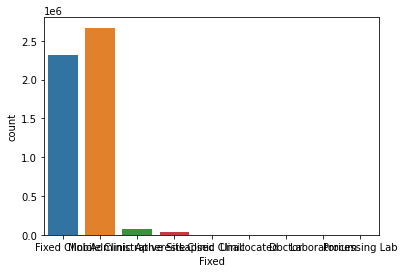

In [32]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
sns.histplot(df, x="Fixed", stat="probability")
sns.countplot(fixed)
print(fixed.value_counts())

In [4]:
df['time_to_return'].isnull().sum()

#df_end=df.loc[df['Visit_Date'] > df['Def_end']]

#print(len(df_end))
#df_end.head()

df_neg=df.loc[df['time_to_return']<0]

print(len(df_neg))
df_neg.head()

0


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,OUTCOME_TYPE,CENSORED,time_to_return


In [5]:
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)
